## **Text Analytics Assignment 1**

In [1]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
import numpy as np
import csv
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import math

Populating the interactive namespace from numpy and matplotlib


**A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?**

In [2]:
realdata = pd.read_csv('Train_rev1.csv', dtype=unicode, encoding='utf-8')
smallset = realdata.sample(n=10000)
#randomly picking 10,000 data points

token = smallset['FullDescription'].map(nltk.word_tokenize)
speechtypes = token.map(nltk.pos_tag)
dfList = speechtypes.tolist()
flat_list = [item for sublist in dfList for item in sublist]

In [3]:
from collections import Counter
import operator

counts = Counter(tag for word,tag in flat_list)
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1))
dfcounts = pd.DataFrame(sorted_counts)

In [4]:
dfcounts['Freq'] = dfcounts[1]/ dfcounts[1].sum()
dfcounts[-5:]


,0,1,Freq
37,DT,201986,0.075349
38,JJ,217249,0.081043
39,IN,258674,0.096496
40,NNP,337560,0.125924
41,NN,460098,0.171636


**A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.**


In [5]:
from nltk import FreqDist

token_list = [item for sublist in token for item in sublist]

#find the frequency top 100 words
fdist1 = FreqDist(w.lower() for w in token_list)
data = fdist1.most_common(100)
df = pd.DataFrame(data)
df.columns= ['words', 'count']

#sort the dataframe and find frequency and zip's law
sorteddf = df.sort_values(by='count', ascending=False)
sorteddf['Rank'] = sorteddf.index + 1
sorteddf[:10]

,words,count,Rank
0,and,107779,1
1,",",93892,2
2,.,86736,3
3,the,85291,4
4,to,82283,5
5,a,61281,6
6,of,57837,7
7,in,41748,8
8,for,34800,9
9,with,29551,10


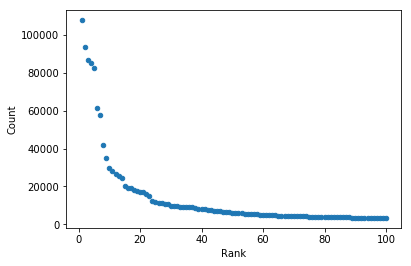

In [6]:
ax = sorteddf.plot(kind='scatter', x='Rank', y='count')
ax.set_xlabel("Rank")
ax.set_ylabel("Count")

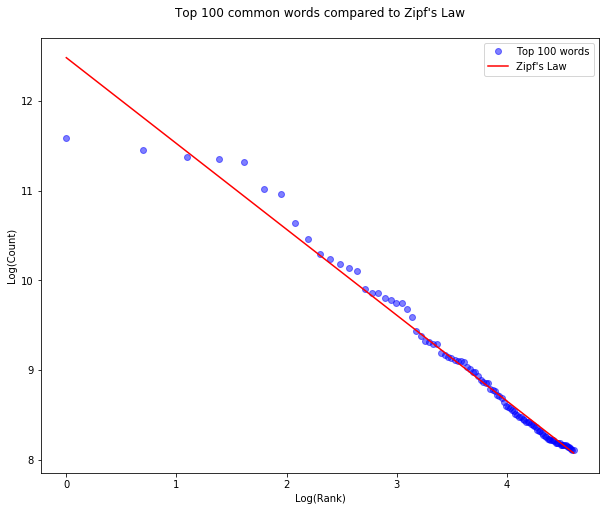

In [7]:
x = np.log(sorteddf['Rank'])
y = np.log(sorteddf['count'])

fit = np.polyfit(x, y, deg = 1)
fitted = fit[0] * x + fit[1]

plt.figure(figsize=(10,8))
plt.plot(x, y, 'bo', alpha = 0.5)
plt.plot(x,fitted,'r')

plt.title('Top 100 common words compared to Zipf\'s Law\n')
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Count)')
plt.legend(['Top 100 words','Zipf\'s Law'])

plt.show()

**A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What are their frequencies?**

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#removing stopwords
stopset = set(stopwords.words('english'))
#stopset.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])

tokens = [w.lower() for w in token_list if not w.lower() in stopset]

In [9]:
#lemmatization
from nltk.stem import WordNetLemmatizer

results = []

lemma = WordNetLemmatizer()

for i in tokens:
    new = lemma.lemmatize(i)
    results.append(new)

In [10]:
from nltk import FreqDist

fdist1 = FreqDist(w for w in results)
datalemmastop = fdist1.most_common(10)
dflemmastop = pd.DataFrame(datalemmastop)
dflemmastop.columns= ['words', 'count']
dflemmastop['Frequency'] = dflemmastop['count']/ len(results)
dflemmastop

,words,count,Frequency
0,",",93892,0.053005
1,.,86736,0.048965
2,****,19077,0.010770
3,:,17220,0.009721
4,experience,17198,0.009709
5,role,12656,0.007145
6,team,12143,0.006855
7,work,11720,0.006616
8,client,11446,0.006462
9,business,11331,0.006397


**B1. Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? **


In [11]:
data = pd.read_csv("Train_rev1.csv")
sample = data.sample(10000, replace=False).copy()

In [12]:
salary = sample['SalaryNormalized']
top75 = np.percentile(salary, 75)

sample['target'] = 0.0
mask = sample['SalaryNormalized'] >= top75
sample['target'][mask]= 1

/Users/shirley/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [14]:
#split data into testing and training setup
train = sample.sample(int(.8*len(sample)), replace=False).copy()
test = sample[~sample.index.isin(train.index.values)]

train_x = train['FullDescription']
train_y = train['target']

test_x = test['FullDescription']
test_y = test['target']

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = None, lowercase=True)

train_x = vectorizer.fit_transform(train_x)
test_x = vectorizer.transform(test_x)

In [15]:
#train the model
model = MultinomialNB().fit(train_x, train_y)

#get the predictions from the model
predicted = model.predict(test_x)

print 'Accuracy: '+ str(metrics.accuracy_score(test_y, predicted))
mat = pd.crosstab(test_y, predicted, rownames=['True'], colnames=['Predicted'], margins=False)
mat # in our case 1 is high and 0 is low

Accuracy: 0.7785


Predicted,0.0,1.0
True,,
0.0,1203,284
1.0,159,354


**B2. Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained. **

We believe that lemmatization will make an impact on the classification accuracy since it can reduce the number of words as well as reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

In [16]:
#split data into testing and training setup
train = sample.sample(int(.8*len(sample)), replace=False).copy()
test = sample[~sample.index.isin(train.index.values)]

train_x = train['FullDescription']
train_y = train['target']

test_x = test['FullDescription']
test_y = test['target']

lemmatizer=WordNetLemmatizer()

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    lemmas = []
    for item in tokens:
        lemmas.append(lemmatizer.lemmatize(item))
    return lemmas

vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = tokenize,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = None, lowercase=True)


train_x = vectorizer.fit_transform(train_x)
test_x = vectorizer.transform(test_x)

In [17]:
#train the model
model = MultinomialNB().fit(train_x, train_y)

#get the predictions from the model
predicted = model.predict(test_x)

print 'Accuracy: '+ str(metrics.accuracy_score(test_y, predicted))
df = pd.DataFrame(confusion_matrix(test_y, predicted))
df.index.name = 'True'
df.columns = ['Predicted  0', '1']
df# in our case 1 is high and 0 is low

Accuracy: 0.784


,Predicted 0,1
True,,
0,1234,262
1,170,334


Just like our suspicions, lemmatization increased our classification accuracy rate in regards to our first approach by about 1%. This is a very marginal effect though, so it does not make much of a difference whether you choose to lemmatize the words or not.

**B3. Now speculate whether stopwords removal from the original data would help increase the accuracy of the model. Take out the stopwords (but do not lemmatize), build a classification model and check the accuracy, and compare with that in B1 & B2.**

We believe that removing stopwords will increase the acuracy since stop words are not needed or useful to predict a jobs salary.

In [18]:
#split data into testing and training setup
train = sample.sample(int(.8*len(sample)), replace=False).copy()
test = sample[~sample.index.isin(train.index.values)]

train_x = train['FullDescription']
train_y = train['target']

test_x = test['FullDescription']
test_y = test['target']

vectorizerstop = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = 'english',   \
                             max_features = None, lowercase=True)

train_x = vectorizerstop.fit_transform(train_x)
test_x = vectorizerstop.transform(test_x)

#train the model
model = MultinomialNB().fit(train_x, train_y)

#get the predictions from the model
predicted = model.predict(test_x)

print 'Accuracy: '+ str(metrics.accuracy_score(test_y, predicted))
mat = pd.crosstab(test_y, predicted, rownames=['True'], colnames=['Predicted'], margins=False)
mat # in our case 1 is high and 0 is low

Accuracy: 0.82


Predicted,0.0,1.0
True,,
0.0,1260,212
1.0,148,380


The accuracy is marginally higher depending on the sample, about ~4% higher for removing stop words. Stop words are not the most important features in predicting Salary, therefore they will not have a big effect whether you remove them or not, nor did lemmitization. But since they are less important, removing them will increase the prediction accuracy.

**Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary. **

In [19]:
def show_most_informative_features(vectorizer, clf, n):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
        
show_most_informative_features(vectorizerstop, model, 10)

	-12.7200	00025          		-4.3588	experience     
	-12.7200	00028          		-4.7126	business       
	-12.7200	001            		-4.8872	role           
	-12.7200	0016           		-4.9293	team           
	-12.7200	0018           		-4.9987	management     
	-12.7200	00am17         		-5.1047	work           
	-12.7200	00am4          		-5.1322	skills         
	-12.7200	00am5          		-5.1475	development    
	-12.7200	00hrs          		-5.2025	client         
	-12.7200	00m            		-5.2256	manager        


**B4.  Use the job descriptions without lemmatiztion and stopword removal. Add parts-of-speech bigrams to the bag-of-words, and run a new classification model. Does the accuracy increase over the results in B1?**

In [20]:
#split data into testing and training setup
train = sample.sample(int(.8*len(sample)), replace=False).copy()
test = sample[~sample.index.isin(train.index.values)]

train_x = train['FullDescription']
train_y = train['target']

test_x = test['FullDescription']
test_y = test['target']
 
def pos_bigram_counter(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens, tagset="universal")
    bigrams = list(nltk.bigrams(pos))
 
    bigram_pos = ((pos1, pos2) for (w1, pos1), (w2, pos2) in bigrams)
    bigram_list = list(bigram_pos)
    string_list = map(' '.join, bigram_list) 
    return string_list

vectorizerstop = CountVectorizer(analyzer = "word",   \
                             tokenizer = pos_bigram_counter,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = None, lowercase=True)

train_x = vectorizerstop.fit_transform(train_x)
test_x = vectorizerstop.transform(test_x)

#train the model
model = MultinomialNB().fit(train_x, train_y)

#get the predictions from the model
predicted = model.predict(test_x)

print 'Accuracy: '+ str(metrics.accuracy_score(test_y, predicted))
mat = pd.crosstab(test_y, predicted, rownames=['True'], colnames=['Predicted'], margins=False)
mat # in our case 1 is high and 0 is low

Accuracy: 0.671


Predicted,0.0,1.0
True,,
0.0,1083,397
1.0,261,259


The accuracy when using parts of speech bigrams to predict high or low salary is dramatically lower than compared to B1. In B1 the accuracy is about 78% while in this question it has reduced to 67%. This shows that paprts of speech bigrams are not good predictors of high or low salary.